In [40]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime
import math
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [45]:
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2019, 11, 1)

In [46]:
df = web.DataReader('INKP.JK','yahoo',start=start,end=end)

In [4]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-11-05,8175.0,6900.0,7450.0,7450.0,21777100.0,6897.304199
2014-11-06,7675.0,7500.0,7625.0,7625.0,6653200.0,7059.321289
2014-11-07,7675.0,7525.0,7525.0,7525.0,2698500.0,6966.739258
2014-11-10,7575.0,7175.0,7250.0,7250.0,2018400.0,6712.141113
2014-11-11,7550.0,7250.0,7500.0,7500.0,797300.0,6943.594238


In [5]:
dfreg = df

## FEATURE ENGINEERING

In [6]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [7]:
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2014-11-05,6897.304199,21777100.0,17.114094,0.0
2014-11-06,7059.321289,6653200.0,2.295082,0.0
2014-11-07,6966.739258,2698500.0,1.993355,0.0
2014-11-10,6712.141113,2018400.0,5.517241,0.0
2014-11-11,6943.594238,797300.0,4.000000,0.0


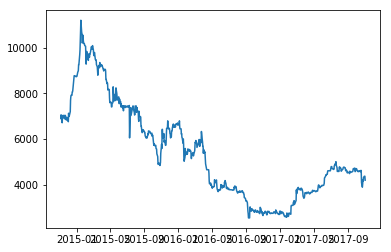

In [8]:
plt.plot(dfreg['Adj Close'])

In [9]:
# Drop missing value
#dfreg.fillna(value=-99999, inplace=True)
dfreg = dfreg.dropna()

In [10]:
# We want to separate 1 percent of the data to forecast
#forecast_out = int(math.ceil(0.01 * len(dfreg)))
forecast_out = 7

In [11]:
forecast_out

7

In [12]:
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)

In [13]:
X = np.array(dfreg.drop(['label'], 1))

In [14]:
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

In [15]:
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

In [16]:
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [17]:
X_train = X
y_train = y

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [19]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [20]:
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [21]:
# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [22]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='uniform')

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=45)

In [24]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

print('The linear regression confidence is ', confidencereg)
print('The quadratic regression 2 confidence is ',confidencepoly2)
print('The quadratic regression 3 confidence is ', confidencepoly3)
print('The knn regression confidence is ', confidenceknn)      

The linear regression confidence is  0.9672801876729832
The quadratic regression 2 confidence is  0.965877472015199
The quadratic regression 3 confidence is  0.9682436445942646
The knn regression confidence is  0.9776551538375287


In [25]:
clf = clfreg

In [26]:
X_lately

array([[-0.55127642, -0.40926491,  0.74264842,  1.68962316],
       [-0.57868573, -0.44947821, -0.23991726, -0.52060454],
       [-0.50559448, -0.46510696,  0.2161873 ,  1.36878036],
       [-0.47818517, -0.47933087, -0.36036222,  0.53835365],
       [-0.47818517, -0.48091131, -0.20050561,  0.01482376],
       [-0.47818517, -0.51216881, -0.83993206,  0.18779619],
       [-0.56041286, -0.4894281 ,  0.41811759, -1.53510025]])

In [27]:
forecast_set = clf.predict(X_lately)
dfreg['Forecast'] = np.nan

In [28]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

In [29]:
for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
    print(len(dfreg.columns),[i])

6 [4241.998876211148]
6 [4149.674649783357]
6 [4327.0019552585]
6 [4367.737673816762]
6 [4363.227091977443]
6 [4358.8165147686705]
6 [4182.251673605267]


In [30]:
next_date

Timestamp('2017-11-09 00:00:00')

In [31]:
dfreg.tail(50)

,Adj Close,Volume,HL_PCT,PCT_change,label,Forecast
Date,,,,,,
2017-09-05,4531.942871,15300.0,0.634249,-0.210970,4551.105469,NaN
2017-09-06,4531.942871,11700.0,0.211416,0.000000,4560.686523,NaN
2017-09-07,4484.036133,93200.0,1.709402,-1.057082,4570.268066,NaN
2017-09-08,4589.430176,171100.0,2.713987,2.569593,4608.592773,NaN
2017-09-11,4541.523926,87000.0,1.265823,-1.043841,4694.824707,NaN
2017-09-12,4541.523926,76700.0,1.054852,0.000000,4694.824707,NaN
2017-09-13,4551.105469,17500.0,0.421053,0.210970,4704.405762,NaN
2017-09-14,4551.105469,54300.0,0.631579,0.000000,4723.568359,NaN
2017-09-15,4560.686523,77800.0,0.420168,0.210526,4723.568359,NaN


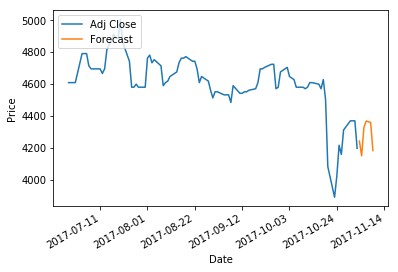

In [32]:
dfreg['Adj Close'].tail(100).plot()
dfreg['Forecast'].tail(100).plot()
plt.legend(loc=2)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [33]:
forecast_set

array([4241.99887621, 4149.67464978, 4327.00195526, 4367.73767382,
       4363.22709198, 4358.81651477, 4182.25167361])

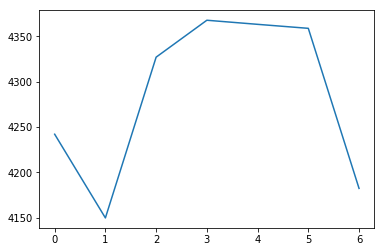

In [34]:
plt.plot(forecast_set)

In [35]:
df[-1:]['Adj Close']

Date
2017-11-02    4196.598145
Name: Adj Close, dtype: float64

In [36]:
forecast_set.min()

4149.674649783357

In [39]:
df['Adj Close'][-1]

4196.59814453125